In [96]:
from mypulp import *
import numpy as np
import itertools
import networkx as nx
import math
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.simplefilter('ignore')

# 巡回セールスマン問題

In [69]:
def solve_tsp_mtz(n, c):
    model = Model('tsp_mtz')
    V = [i for i in range(n)]

    ## 変数 ##
    x, u = {}, {}
    for i, j in itertools.product(V, V):
        if i != j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
    for i in V:
        u[i] = model.addVar(vtype='C', lb=0, ub=n-1, name=f'u_{i}')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, j] for j in V if j!=i) == 1)
        model.addConstr(quicksum(x[j, i] for j in V if j!=i) == 1)
        
        for j in range(1, n):
            if i != j:
                #model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) <= u[j])
                model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) + (n-3)*x[j, i] <= u[j])
    for i in range(1, n):
        model.addConstr(1 + (1-x[0, i]) + (n-3)*x[i, 0] <= u[i])
        model.addConstr(u[i] <= (n-1) - (1-x[i, 0] - (n-3)*x[0, i]))
    model.setObjective(quicksum(c[i, j] * x[i, j] for i, j in x), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, u
    
    return model

Optimal Value: 2895.1716448889797


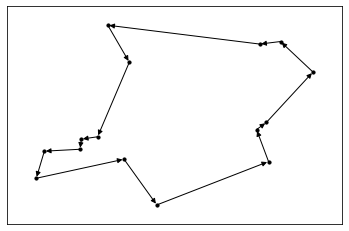

In [70]:
# n点からなるグラフの生成
n = 15
V = [i for i in range(n)]

# コスト行列
np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
c = np.sqrt((x.reshape(-1,1) - x)**2 + (y.reshape(-1,1) - y)**2)  

p = {i: (x[i], y[i]) for i in range(n)}

model = solve_tsp_mtz(n, c)
model.optimize()
print(f'Optimal Value: {model.ObjVal}')

# 解の描画
x, u = model.__data
eps = 1.0e-6
optsol = []
for i, j in x:
    if x[i, j].X > eps:
        optsol.append([i, j])

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(optsol)
nx.draw_networkx(G, draw_arrows=True, pos=p, node_color='k', node_size=10, with_labels=False)
plt.show()

# 多目的の巡回セールスマン問題

## 加重和法

In [213]:
# 多目的最適化問題を解いてmodelを返す関数
def solve_multiobject_tsp(n, c, t, alpha):
    model = Model('tsp_mtz')
    V = [i for i in range(n)]

    ## 変数 ##
    x, u = {}, {}
    for i, j in itertools.product(V, V):
        if i != j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
    for i in V:
        u[i] = model.addVar(vtype='C', lb=0, ub=n-1, name=f'u_{i}')
    C = model.addVar(vtype='C', name='C')
    T = model.addVar(vtype='C', name='T')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, j] for j in V if j!=i) == 1)
        model.addConstr(quicksum(x[j, i] for j in V if j!=i) == 1)
        
        for j in range(1, n):
            if i != j:
                #model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) <= u[j])
                model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) + (n-3)*x[j, i] <= u[j])
    for i in range(1, n):
        model.addConstr(1 + (1-x[0, i]) + (n-3)*x[i, 0] <= u[i])
        model.addConstr(u[i] <= (n-1) - (1-x[i, 0] - (n-3)*x[0, i]))
        
    model.addConstr(T == quicksum(t[i, j] * x[i, j] for (i, j) in x), 'Time')
    model.addConstr(C == quicksum(c[i, j] * x[i, j] for (i, j) in x), 'Cost')
    
    model.setObjective(quicksum((c[i, j] + alpha*t[i, j]) * x[i, j] for i, j in x), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, u, T, C
    return model

In [223]:
# パレート最適解を列挙する関数
def explore(C1, C2, T1, T2, set_pareto):
    alpha = (C1 - C2) / (T2 - T1)
    model = solve_multiobject_tsp(n, c, t, alpha)
    model.optimize()
    
    _, _, T, C = model.__data
    TM, CM = T.X, C.X
    
    # 解の集合が更新されなければ修了 + TM=T1orT2となって次のステップで0で割られることを防ぐ
    if ((TM, CM) in set_pareto) or TM == T1 or TM == T2:
        return set_pareto 
    
    # 新しいパレート最適解が得られた場合は再帰的に呼び出し
    #if TM > T1:
    if not (TM >= T1 and CM >= C1):
        set_pareto.add((TM, CM))
        explore(C1, CM, T1, TM, set_pareto)
    #if T2 > TM:
    if not (TM >= T2 and CM >= C2):
        set_pareto.add((TM, CM))
        explore(CM, C2, TM, T2, set_pareto)
    
    return set_pareto

In [224]:
## 入力
# n点からなるグラフの生成
n = 15
V = [i for i in range(n)]

# コスト行列
np.random.seed(1234)
x1 = np.random.randint(low=0, high=100, size=n)
y1 = np.random.randint(low=0, high=100, size=n)
c = np.sqrt((x1.reshape(-1,1) - x1)**2 + (y1.reshape(-1,1) - y1)**2)
c = np.round(c)

# 時間行列
np.random.seed(7)
x2 = np.random.randint(low=0, high=100, size=n)
y2 = np.random.randint(low=0, high=100, size=n)
t = np.sqrt((x2.reshape(-1,1) - x2)**2 + (y2.reshape(-1,1) - y2)**2)
t = np.round(t)

In [227]:
## パレート最適解の両端点
set_pareto = set()

model = solve_multiobject_tsp(n, c, t, alpha=1)
x, u, T, C = model.__data

# 時間最小
model.setObjective(T, GRB.MINIMIZE)
model.update()
model.optimize()
T1, C1 = T.X, C.X
set_pareto.add((T1, C1))

# コスト最小
model.setObjective(C, GRB.MINIMIZE)
model.update()
model.optimize()
T2, C2 = T.X, C.X
set_pareto.add((T2, C2))

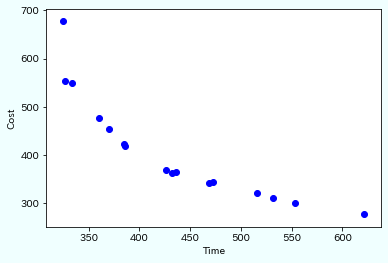

In [228]:
set_pareto = explore(C1, C2, T1, T2, set_pareto)

plt.figure(facecolor='azure')
plt.xlabel('Time')
plt.ylabel('Cost')

for i in set_pareto:
    plt.scatter(i[0], i[1], color='blue')  

## 制約法
* コスト最小化問題の解が複数ある場合は，パレート最適解以外の解も得られてしまう可能性がある

In [208]:
# 最適化問題を解いてmodelを返す関数
def solve_multiobject_tsp(n, c, t):
    model = Model('tsp_mtz')
    V = [i for i in range(n)]

    ## 変数 ##
    x, u = {}, {}
    for i, j in itertools.product(V, V):
        if i != j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
    for i in V:
        u[i] = model.addVar(vtype='C', lb=0, ub=n-1, name=f'u_{i}')
    C = model.addVar(vtype='C', name='C')
    T = model.addVar(vtype='C', name='T')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, j] for j in V if j!=i) == 1)
        model.addConstr(quicksum(x[j, i] for j in V if j!=i) == 1)
        
        for j in range(1, n):
            if i != j:
                #model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) <= u[j])
                model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) + (n-3)*x[j, i] <= u[j])
    for i in range(1, n):
        model.addConstr(1 + (1-x[0, i]) + (n-3)*x[i, 0] <= u[i])
        model.addConstr(u[i] <= (n-1) - (1-x[i, 0] - (n-3)*x[0, i]))
        
    model.addConstr(T == quicksum(t[i, j] * x[i, j] for (i, j) in x), 'Time')
    model.addConstr(C == quicksum(c[i, j] * x[i, j] for (i, j) in x), 'Cost')
    
    model.setObjective(quicksum(c[i, j] * x[i, j] for i, j in x), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, u, T, C
    return model

In [209]:
## 入力
# n点からなるグラフの生成
n = 15
V = [i for i in range(n)]

# コスト行列
np.random.seed(1234)
x1 = np.random.randint(low=0, high=100, size=n)
y1 = np.random.randint(low=0, high=100, size=n)
c = np.sqrt((x1.reshape(-1,1) - x1)**2 + (y1.reshape(-1,1) - y1)**2)
c = np.round(c)

# 時間行列
np.random.seed(7)
x2 = np.random.randint(low=0, high=100, size=n)
y2 = np.random.randint(low=0, high=100, size=n)
t = np.sqrt((x2.reshape(-1,1) - x2)**2 + (y2.reshape(-1,1) - y2)**2)
t = np.round(t)

In [210]:
## パレート最適解の両端点
set_pareto = set()

# 時間最小
model = solve_multiobject_tsp(n, c, t)
x, u, T, C = model.__data
model.setObjective(T, GRB.MINIMIZE)
model.update()
model.optimize()
T1, C1 = T.X, C.X
set_pareto.add((T1, C1))

# コスト最小
model.setObjective(C, GRB.MINIMIZE)
model.update()
model.optimize()
T2, C2 = T.X, C.X
set_pareto.add((T2, C2))

コスト最小化問題に時間の上限の制約を適宜加えていく

In [211]:
continue_ = True

# 時間を無視したコスト最小化問題のT
presentT = T2

while continue_:
    model.addConstr(quicksum(t[i, j] * x[i, j] for (i, j) in x) <= presentT - 1)
    model.update()
    model.optimize()

    T_, C_ = T.X, C.X
    set_pareto.add((T_, C_))
    presentT = T_
    
    # コストを無視した時間最小化問題の解までTが小さくなれば終了（それ以上は実行可能解がない）
    if presentT <= T1:
        continue_ = False

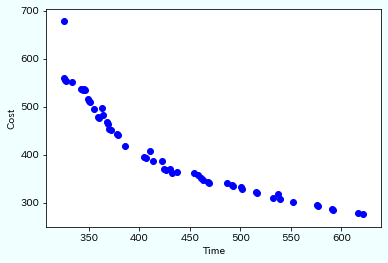

In [212]:
plt.figure(facecolor='azure')
plt.xlabel('Time')
plt.ylabel('Cost')

for i in set_pareto:
    plt.scatter(i[0], i[1], color='blue')  